### Environment setup:
Don't use python 3.7 because it has problems connecting to windows Jupyter Notebook! Use 3.6 instead.  
Conda can't install CVXPY v.1.0.x on Windows, must use pip instead. Use possibly as last step, because conda can't see these packages.  
Pip will need VS2019 Build Tools (or Microsoft Visual C++ Compiler Package for Python2, don't know which did the trick).  

`
conda create -n cvx python=3.6  
conda activate cvx  
conda install nb_conda  
python -m ipykernel install --user --name cvx --display-name "Python (cvx)"  
conda install cvxopt  
conda install matplotlib  
pip install cvxpy  
`

In [1]:
%config IPCompleter.greedy=True
# needs module cvxopt: so that cvxpy registers CVXOPT and GLPK solvers
# needs module cylp: so that cvxpy registers Coinor's CBC solver
# needs module xpress: so that cvxpy reigisters Fico Xpress Interface
import cvxpy as cp
import numpy as np
import time
import matplotlib.pyplot as plt
from multiprocessing import Pool
print('CVXPY version: ', cp.__version__)
print('CVXPY solvers: ', cp.installed_solvers())

CVXPY version:  1.0.21
CVXPY solvers:  ['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'XPRESS', 'GLPK_MI', 'CBC', 'SCS', 'GUROBI', 'OSQP', 'GUROBI']


In [8]:
# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cp.Minimize((x - y)**2)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 0.9999999997614037
optimal var 1.0000000000119962 -1.1996184170199075e-11


In [9]:
# Replace the objective.
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print("optimal value", prob2.solve())

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob2.constraints[1:]
prob3 = cp.Problem(prob2.objective, constraints)
print("optimal value", prob3.solve())

optimal value 0.9999999999945574
optimal value 2.999999999974675


In [10]:
x = cp.Variable()

# An infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: infeasible
optimal value inf
status: unbounded
optimal value -inf


In [63]:
# Bounded least squares

# Problem data.
m = 3  # data points
n = 1  # nof input dims wout bias (for 2D space you need 1D input)
np.random.seed(1)
A = np.random.randn(m, n+1)  # bias
b = np.random.randn(m)

A[:,0] = 1  # bias

# Construct the problem.
x = cp.Variable(n+1)
objective = cp.Minimize(cp.sum_squares(A*x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
print(result)
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

2.7999808821560155
[0.99999988 0.4399245 ]
[6.42320598e-09 1.31836468e-08]


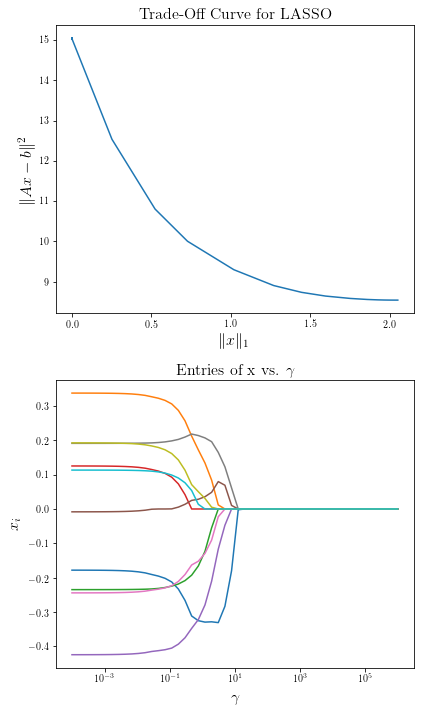

In [65]:
# Problem data.
n = 15  # data
m = 10  # dims
np.random.seed(1)
A = np.random.randn(n, m)
b = np.random.randn(n)
# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

# Construct the problem.
x = cp.Variable(m)
error = cp.sum_squares(A*x - b)
obj = cp.Minimize(error + gamma*cp.norm(x, 1))
prob = cp.Problem(obj)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []
gamma_vals = np.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cp.norm(x, 1).value)
    x_values.append(x.value)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(6,10))

# Plot trade-off curve.
plt.subplot(211)
plt.plot(l1_penalty, sq_penalty)
plt.xlabel(r'$\|x\|_1$', fontsize=16)
plt.ylabel(r'$\|Ax-b\|^2$', fontsize=16)
plt.title('Trade-Off Curve for LASSO', fontsize=16)

# Plot entries of x vs. gamma.
plt.subplot(212)
for i in range(m):
    plt.plot(gamma_vals, [xi[i] for xi in x_values])
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel(r'$x_{i}$', fontsize=16)
plt.xscale('log')
plt.title(r'$\textrm{Entries of x vs. }\gamma$', fontsize=16)

plt.tight_layout()
plt.show()

In [95]:
# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    result = prob.solve()
    return x.value

# Parallel computation pool.
pool = Pool(processes = 4)

start = time.time()
x_values = pool.map(get_x, gamma_vals)
end = time.time()
print(end - start)

print(np.linalg.norm(x_values, axis=1))

0.14888763427734375
[7.37203792e-01 7.37172014e-01 7.37120810e-01 7.37038552e-01
 7.36907203e-01 7.36697315e-01 7.36361775e-01 7.35824853e-01
 7.34963359e-01 7.33624515e-01 7.31424868e-01 7.28029132e-01
 7.22602375e-01 7.17287192e-01 7.09901743e-01 6.98308759e-01
 6.77801335e-01 6.49862894e-01 6.19198740e-01 5.82801038e-01
 5.31009040e-01 4.59948483e-01 3.96903832e-01 3.20229688e-01
 1.90366265e-01 2.25279773e-03 6.80034679e-10 4.64168071e-10
 4.68124305e-11 7.79113276e-12 2.44299104e-12 2.55916859e-12
 3.14365648e-12 2.56360960e-13 4.62216274e-12 1.85373147e-11
 4.08637743e-12 1.35404651e-12 1.81651425e-12 1.65073989e-14
 5.84466669e-13 2.39748228e-11 3.33002401e-11 1.40317799e-11
 4.11875970e-12 2.67903999e-11 1.30364009e-13 2.55193235e-12
 5.89493079e-12 6.89066742e-12]


In [96]:
x = cp.Variable()
a = cp.Parameter(nonneg=True)
print("curvature of x:", x.curvature)
print("curvature of a:", a.curvature)
print("curvature of square(x):", cp.square(x).curvature)
print("curvature of sqrt(x):", cp.sqrt(x).curvature)

curvature of x: AFFINE
curvature of a: CONSTANT
curvature of square(x): CONVEX
curvature of sqrt(x): CONCAVE


In [106]:
x = cp.Variable()
y = cp.Variable()
# DCP problems.
prob1 = cp.Problem(cp.Minimize(cp.square(x - y)), [x + y >= 0])
prob2 = cp.Problem(cp.Maximize(cp.sqrt(x - y)), [2*x - 3 == y, cp.square(x) <= 2])
print("prob1 is DCP:", prob1.is_dcp())
print("prob2 is DCP:", prob2.is_dcp())
print()
# Non-DCP problems.
# A non-DCP objective.
obj = cp.Maximize(cp.square(x))
prob3 = cp.Problem(obj)
print("prob3 is DCP:", prob3.is_dcp())
print("Maximize(square(x)) is DCP:", obj.is_dcp())
# A non-DCP constraint.
prob4 = cp.Problem(cp.Minimize(cp.square(x)), [cp.sqrt(x) <= 2])
print("prob4 is DCP:", prob4.is_dcp())
print("sqrt(x) <= 2 is DCP:", (cp.sqrt(x) <= 2).is_dcp())

prob1 is DCP: True
prob2 is DCP: True

prob3 is DCP: False
Maximize(square(x)) is DCP: False
prob4 is DCP: False
sqrt(x) <= 2 is DCP: False


In [2]:
print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS']


In [6]:
# Solving a problem with different solvers.
x = cp.Variable(2)
obj = cp.Minimize(x[0] + cp.norm(x, 1))
constraints = [x >= 2]
prob = cp.Problem(obj, constraints)

prob.solve(solver=cp.ECOS)
print("optimal value with ECOS:", prob.value)
prob.solve(solver=cp.ECOS_BB)
print("optimal value with ECOS_BB:", prob.value)
prob.solve(solver=cp.SCS)
print("optimal value with SCS:", prob.value)
prob.solve(solver=cp.CVXOPT)
print("optimal value with CVXOPT:", prob.value)
prob.solve(solver=cp.GLPK)
print("optimal value with GLPK:", prob.value)
prob.solve(solver=cp.GLPK_MI)
print("optimal value with GLPK_MI:", prob.value)

optimal value with ECOS: 5.999999995510096
optimal value with ECOS_BB: 5.999999995510096
optimal value with SCS: 5.999482265313127
optimal value with CVXOPT: 6.000000005119901
optimal value with GLPK: 6.0
optimal value with GLPK_MI: 6.0


In [20]:
prob.solve(solver=cp.ECOS, verbose=True)
print("optimal value with ECOS:", prob.value)
print('solve time seconds: ', prob.solver_stats.solve_time)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.667e-01  +7.067e-01  +6e+00  6e-01  1e-02  1e+00  9e-01    ---    ---    1  1  - |  -  - 
 1  +3.500e+00  +3.925e+00  +1e+00  3e-01  4e-03  8e-01  2e-01  0.9890  2e-01   1  1  1 |  0  0
 2  +5.716e+00  +5.825e+00  +2e-01  6e-02  8e-04  2e-01  4e-02  0.9091  8e-02   1  1  1 |  0  0
 3  +5.997e+00  +5.998e+00  +3e-03  7e-04  1e-05  2e-03  5e-04  0.9881  1e-04   1  1  1 |  0  0
 4  +6.000e+00  +6.000e+00  +3e-05  8e-06  1e-07  3e-05  5e-06  0.9890  1e-04   1  1  1 |  0  0
 5  +6.000e+00  +6.000e+00  +3e-07  9e-08  1e-09  3e-07  6e-08  0.9890  1e-04   1  0  0 |  0  0
 6  +6.000e+00  +6.000e+00  +4e-09  1e-09  1e-11  3e-09  6e-10  0.9890  1e-04   1  0  0 |  0  0

OPTIMAL (within feastol=9.9e-10, reltol=6.2e-10, abstol=3.7e-09).
Runtime: 0.000186 seconds.

optimal value with ECOS: 5.999999995510096
solv

In [32]:
# WARM START for sequential parametrized runs
# (~2+2 mins, works only with ECOS or SCS and even then doesen't seem effective)
# Better: use parallellization
m = 2000
n = 1000
np.random.seed(1)
A = np.random.randn(m, n)
b = cp.Parameter(m)
# Construct the problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.sum_squares(A*x - b)), [x >= 0])
b.value = np.random.randn(m)

solver = cp.SCS
prob.solve(solver=solver)
if prob.solver_stats:
    print(f'{prob.solver_stats.solver_name} first solve time: {prob.solver_stats.solve_time}')
b.value = np.random.randn(m)
prob.solve(solver=solver, warm_start=True)
if prob.solver_stats:
    print(f'{prob.solver_stats.solver_name} second solve time: {prob.solver_stats.solve_time}')

SCS first solve time: 75286.274203
SCS second solve time: 90956.509937


In [86]:
# Based on formulation described
#    @ https://en.wikipedia.org/wiki/Travelling_salesman_problem (February 2016)

np.random.seed(1)

N = 14
distances = np.random.rand(N, N)
distances = (distances + distances.T)/2  # make symmetric = symmetric-TSP

# VARS (n^2+n)  // efficient model has: (n^2-n) + (n-1) = n^2-1 vars
x = cp.Variable((N, N), boolean=True)
u = cp.Variable(N)

# CONSTRAINTS (n^2+n)
constraints = []
# degree constraints (2n):
for j in range(N):  # incoming sum==1
    indices = np.hstack((np.arange(0, j), np.arange(j + 1, N)))
    constraints.append(cp.sum(x[indices, j]) == 1)
for i in range(N):  # outgoing sum==1
    indices = np.hstack((np.arange(0, i), np.arange(i + 1, N)))
    constraints.append(cp.sum(x[i, indices]) == 1)
# MTZ SEC-s (Miller-Tucker-Zemlin Subtour Elimination Constraints) (n^2-n):
for i in range(1, N):
    for j in range(1, N):
        if i != j:
            constraints.append(u[i] - u[j] + (N-1)*x[i, j] <= (N-1)-1)

# OBJ
obj = cp.Minimize(cp.sum(cp.multiply(distances, x)))

# PROBLEM
prob = cp.Problem(obj, constraints)

# SOLVE
start = time.time()
prob.solve(solver=cp.GLPK_MI)
end = time.time()
print(f'Run time: ', end - start)

print(prob.value)
print(u.value)
print(np.around(x.value) if x.value is not None else 'no x')
if prob.solver_stats:
    print(f'{prob.solver_stats.solver_name} solve time: {prob.solver_stats.solve_time}')

Run time:  0.45611572265625
3.3601165503609165
[ 0.  3. -4. -2.  2.  1.  8.  0. -1.  5. -3.  7.  6.  4.]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
GLPK_MI solve time: None


# ACO

In [1]:
%config IPCompleter.greedy=True
import cvxpy as cp
import numpy as np
import time
import matplotlib.pyplot as plt
from multiprocessing import Pool
print('CVXPY version: ', cp.__version__)
print('CVXPY solvers: ', cp.installed_solvers())

CVXPY version:  1.0.21
CVXPY solvers:  ['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'XPRESS', 'GLPK_MI', 'CBC', 'SCS', 'GUROBI', 'OSQP', 'GUROBI']


In [34]:
# Manually build ACO example
n=7
m=4
# activities = [[0], [1,2], [3,4], [5,6]]
activities = np.zeros((n,m))
activities[range(n),[0,1,1,2,2,3,3]] = 1
windows = np.array([[0,15], [0,10], [6,10], [0,10], [0,10], [0,5], [6,10]])
times = np.ones((n,n)) * 100
times[0,1] = 2; times[0,2] = 1; times[1,3] = 2; times[1,4] = 2
times[2,3] = 2; times[2,4] = 2; times[3,5] = 2; times[3,6] = 2
times[4,5] = 1; times[4,6] = 1; times[5,0] = 1; times[6,0] = 5
costs = times
durations = np.zeros((n,1))
start_fixed_time = 0
finish_max_time = 20
available_total_time = finish_max_time - start_fixed_time

In [28]:
def locs_of_act(act, negate=False):
    chosen_acts = [act] if not negate else list(range(act))+list(range(act+1, activities.shape[1]))
    return np.nonzero(np.sum(activities[:, chosen_acts], axis=1))[0]
    
def mask_from(act, frm=True):
    mask = np.ones((n,n))-np.identity(n)
    mask[locs_of_act(act, negate=frm),:] = 0
    mask[:,locs_of_act(act, negate=(not frm))] = 0
    return mask

def mask_to(act):
    return mask_from(act, frm=False)

def mask_intra(act):
    mask = np.ones((n,n))-np.identity(n)
    mask[locs_of_act(act, negate=True),:] = 0
    mask[:,locs_of_act(act, negate=True)] = 0
    return mask

def mask_fromto(act1, act2):
    loc1 = locs_of_act(act1)
    loc2 = locs_of_act(act2)
    row, col = zip(*[(i,j) for i in loc1 for j in loc2])
    mask = np.zeros((n,n))
    mask[row, col] = 1
    return mask

In [29]:
print(locs_of_act(3, negate=True))
print(mask_from(1))
print(mask_to(2))
print(mask_intra(2))
print(mask_fromto(1,2))

[0 1 2 3 4]
[[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [41]:
# VARS (n^2+m)
x = cp.Variable((n, n), boolean=True)
t = cp.Variable(m)

# CONSTRAINTS (m^2+4m+n)
constraints = []

for i in range(n):
    noti = np.hstack((np.arange(0, i), np.arange(i + 1, n)))
    constraints.append(cp.sum(x[i, noti]) == cp.sum(x[noti, i]))  # C1: flow constraints for nodes (n)
    
for k in range(m):
    _from = mask_from(k)
    _to = mask_to(k)
    _intra = mask_intra(k)
    _open = _from*windows[:,:1]
    _close = _from*(windows[:,1:]-durations)
    constraints.append(cp.sum(cp.multiply(_from, x)) == 1)    # C2: cluster outflow constraints (m)
    constraints.append(cp.sum(cp.multiply(_to, x)) == 1)      # C3: cluster inflow constraints (m)
    constraints.append(cp.sum(cp.multiply(_intra, x)) == 0)   # C4: no intra-cluster arcs (m)
    constraints.append(t[k] >= cp.sum(cp.multiply(_open, x)))   # C5: activity starts after opening (m)
    constraints.append(t[k] <= cp.sum(cp.multiply(_close, x)))  # C6: activity ends before closing (m)
    

# MTZ-like SEC-s (Miller-Tucker-Zemlin-like Subtour Elimination Constraints):
for k in range(1, m):
    _fromk = mask_from(k)
    d = cp.sum(cp.multiply(_fromk*durations, x))
    from_ready = t[k] + d
    for l in range(0, m):
        if k != l:
            _fromto = mask_fromto(k,l)
            fromto_arc = cp.sum(cp.multiply(_fromto, x))
            fromto_time = cp.sum(cp.multiply(_fromto*times, x))
            to_enter = t[l]
            T = available_total_time
            constraints.append(to_enter - from_ready >= fromto_time - T + T*fromto_arc)    # C7 ((m-1)^2)
    # additional starting time offsets
    _fromhome_tok = mask_fromto(0,k)
    firsttrip_time = cp.sum(cp.multiply(_fromhome_tok*times, x))
    enter_time = t[k]
    constraints.append(enter_time - start_fixed_time >= firsttrip_time)                    # C8 (m-1)


# OBJ
obj = cp.Minimize(t[0])  # minimize time of home arrival

# PROBLEM
prob = cp.Problem(obj, constraints)

# SOLVE
start = time.time()
prob.solve(solver=cp.XPRESS, verbose=True)  # GLPK_MI, CBC, XPRESS, GUROBI
end = time.time()

print("status:", prob.status)
print("optimal value", prob.value)
itinerary = []
if x.value is not None:
    itinerary.append(0)
    for _ in range(m):
        cur = itinerary[-1]
        nxt = np.argmax(x.value[cur])
        itinerary.append(nxt)
print(f'itinerary:  {itinerary}')
print(f'entertimes: {t.value}')
print(np.around(x.value) if x.value is not None else 'no x')
print(f'Run time: ', end - start)
if prob.solver_stats:
    print(f'{prob.solver_stats.solver_name} solve time: {prob.solver_stats.solve_time}')

status: optimal
optimal value 6.0
itinerary:  [0, 1, 4, 5, 0]
entertimes: [6. 2. 4. 5.]
[[-0.  1.  0. -0. -0. -0. -0.]
 [-0. -0. -0. -0.  1. -0. -0.]
 [-0. -0. -0. -0.  0. -0. -0.]
 [-0. -0. -0. -0. -0. -0.  0.]
 [-0. -0. -0. -0. -0.  1. -0.]
 [ 1. -0. -0. -0. -0. -0. -0.]
 [ 0. -0. -0. -0. -0. -0. -0.]]
Run time:  0.08808517456054688
XPRESS solve time: None


# Sparse Model

In [39]:
# VARS (n^2+2n)
x = cp.Variable((n, n), boolean=True)
y = cp.Variable(n, boolean=True)
t = cp.Variable(n)

# CONSTRAINTS (m^2+4m+n)
constraints = []

for i in range(n):
    noti = np.hstack((np.arange(0, i), np.arange(i + 1, n)))
    constraints.append(cp.sum(x[i, noti]) == cp.sum(x[noti, i]))  # C1: flow constraints for nodes (n)
    constraints.append(cp.sum(x[i, noti]) == y[i])                # C1+: sparse node selection variable (n)
    _open = windows[i, 0]
    _close = windows[i, 1]-durations[i, 0]
    if _open>0:
        constraints.append(_open*y[i] <= t[i])                        # C5: activity starts after opening (n)
    else:
        constraints.append(0 <= t[i])
    if _close>0:
        constraints.append(_close*y[i] >= t[i])                       # C6: activity ends before closing (n)
    else:
        constraints.append(0 >= t[i])

for k in range(m):
    constraints.append(cp.sum(y[locs_of_act(k)]) == 1)       # C2-3-4: only one node per cluster is sel (m)

# MTZ-like SEC-s (Miller-Tucker-Zemlin-like Subtour Elimination Constraints):
t_tot = available_total_time
t_min = start_fixed_time
for i in range(1, n):
    for j in range(0, n):
        if i != j:                                                   
            _mindiff = durations[i, 0] + times[i, j]
            _maxdiff = t_min + t_tot - durations[i, 0]
            constraints.append(t[j] - t[i] >= -_maxdiff + (_maxdiff + _mindiff)*x[i, j])   # C7 (n-1)^2
    constraints.append(t[i] >= (t_min + times[0, i])*x[0, i])                              # C8 (n-1)
    
# OBJ
obj = cp.Minimize(t[0])  # minimize time of home arrival

# PROBLEM
prob = cp.Problem(obj, constraints)

# SOLVE
start = time.time()
prob.solve(solver=cp.XPRESS, verbose=True)  # GLPK_MI, CBC, XPRESS, GUROBI
end = time.time()

print("status:", prob.status)
print("optimal value", prob.value)
itinerary = []
if x.value is not None:
    itinerary.append(0)
    for _ in range(m):
        cur = itinerary[-1]
        nxt = np.argmax(x.value[cur])
        itinerary.append(nxt)
print(f'itinerary:  {itinerary}')
print(f'entertimes: {t.value}')
print(np.around(x.value) if x.value is not None else 'no x')
print(f'Run time: ', end - start)
if prob.solver_stats:
    print(f'{prob.solver_stats.solver_name} solve time: {prob.solver_stats.solve_time}')

status: optimal
optimal value 6.0
itinerary:  [0, 1, 4, 5, 0]
entertimes: [ 6.  2.  0.  0.  4.  5. -0.]
[[-0.  1.  0. -0. -0. -0. -0.]
 [-0. -0. -0. -0.  1. -0. -0.]
 [-0. -0. -0. -0.  0. -0. -0.]
 [-0. -0. -0. -0. -0. -0.  0.]
 [-0. -0. -0. -0. -0.  1. -0.]
 [ 1. -0. -0. -0. -0. -0. -0.]
 [ 0. -0. -0. -0. -0. -0. -0.]]
Run time:  3.823817014694214
XPRESS solve time: None


In [43]:
print(f'nof vars: {prob.variables()}')
print(f'nof cons: {len(prob.constraints)}')
print(f'data:     {prob.get_data()}')

nof vars: [Variable((7,)), Variable((7, 7), boolean=True), Variable((7,), boolean=True)]
nof cons: 32
data:     None


In [36]:
po = prob.get_problem_data(solver=cp.XPRESS)[0]
print(f'pdata[0]: {po.keys()}')
print(f'    pdata[0].objective:     {po["objective"]}')
# print(f'    pdata[0].constraints:   {po["constraints"]}')
# print(f'    pdata[0].bool_vars_idx: {po["bool_vars_idx"]}')
# print(f'    pdata[0].int_vars_idx:  {po["int_vars_idx"]}')
print(f'pdata[1]: {type(prob.get_problem_data(solver=cp.XPRESS)[1])}')
print(f'pdata[2]: {type(prob.get_problem_data(solver=cp.XPRESS)[2])}')

pdata[0]: dict_keys(['objective', 'constraints', 'bool_vars_idx', 'int_vars_idx'])
    pdata[0].objective:     <cvxpy.lin_ops.lin_op.LinOp object at 0x000002362131A160>
pdata[1]: <class 'cvxpy.reductions.solvers.solving_chain.SolvingChain'>
pdata[2]: <class 'list'>
